In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.vector_ar.vecm import coint_johansen

from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

#### Data

In [2]:
resolution = '5m'
perps = ['ZEC-PERP', 'XMR-PERP']

ohlc = {}
prices = {}
for perp in perps:
    data = []
    try:
        data = pd.read_parquet('C:/Users/Walid/Desktop/Workspace/data/{}_{}.parquet.gzip'.format(perp, resolution))
    except:
        print('Cannot find {} data'.format(perp))
    
    if len(data) > 0:
        data['startTime'] = data['startTime'].apply(lambda x: datetime.fromisoformat(x))
        ohlc[perp] = data.set_index('startTime')
        prices[perp] = ohlc[perp]['close']

prices = pd.DataFrame(prices).dropna()

#### Mean reversion (static)

##### Trading Signals

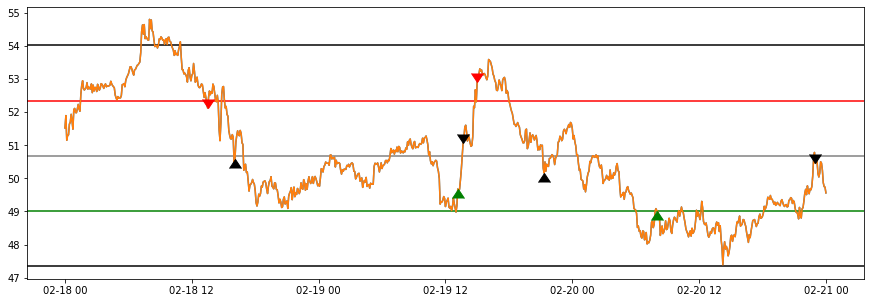

In [3]:
formation_start_time = datetime.fromisoformat('2022-02-18 00:00:00+00:00')
formation_end_time = datetime.fromisoformat('2022-02-21 00:00:00+00:00')
trading_start_time = datetime.fromisoformat('2022-02-18 00:00:00+00:00')
trading_end_time = datetime.fromisoformat('2022-02-21 00:00:00+00:00')


# Make mean reverting portfolio
formation_prices = prices[formation_start_time:formation_end_time]
jres = coint_johansen(formation_prices, 0, 1)
cointegrated = jres.max_eig_stat[0] > jres.max_eig_stat_crit_vals[0][1]
evec = jres.evec[0]
formation_portfolio = (evec * formation_prices).sum(axis=1)
formation_mean = formation_portfolio.mean()
formation_std = formation_portfolio.std()

trading_prices = prices[trading_start_time:trading_end_time]
trading_portfolio = (evec * trading_prices).sum(axis=1)


# Trading positions
positions = [0, 0]
std_multiple = 1
long_signal = formation_mean - formation_std * std_multiple
short_signal = formation_mean + formation_std * std_multiple
exit_signal = formation_mean
long_stop_signal = formation_mean - formation_std * std_multiple * 2
short_stop_signal = formation_mean + formation_std * std_multiple * 2
for i in range(2, len(trading_portfolio.index)):
    if trading_portfolio.iloc[i-2] < long_signal and trading_portfolio.iloc[i-1] > long_signal:
        # open long
        positions.append(1)
    elif trading_portfolio.iloc[i-2] > short_signal and trading_portfolio.iloc[i-1] < short_signal:
        # open short
        positions.append(-1)
    elif positions[i-2] == 1 and trading_portfolio.iloc[i-1] > exit_signal:
        # close long
        positions.append(0)
    elif positions[i-1] == -1 and trading_portfolio.iloc[i-1] < exit_signal:
        # close short
        positions.append(0)
    elif positions[i-1] == 1 and trading_portfolio.iloc[i-1] < long_stop_signal:
        # Take loss
        positions.append(0)
    elif positions[i-1] == -1 and trading_portfolio.iloc[i-1] > short_stop_signal:
        # Take loss
        positions.append(0)
    else:
        positions.append(positions[i-1])


taker_fee = 0.0007
trades = []
for i in range(1, len(positions)):
    # Position opened
    if positions[i-1] == 0 and positions[i] != 0:
        open_spread = trading_portfolio.iloc[i]
        open_trade_index = i

    # Position closed (force close if at last trading bar)
    if positions[i-1] != 0 and (positions[i] == 0 or i == len(positions) - 1):
        open_spread = trading_portfolio.iloc[open_trade_index]
        close_spread = trading_portfolio.iloc[i]
        pnl = ((close_spread - close_spread * taker_fee) - (open_spread - open_spread * taker_fee)) * positions[i-1]

        trades.append({
            'position': 'long' if positions[i-1] > 0 else 'short',
            'open_date': trading_portfolio.index[open_trade_index],
            'open_spread': open_spread,
            'close_date': trading_portfolio.index[i],
            'close_spread': close_spread,
            'pnl': pnl,
            'duration': trading_portfolio.index[i] - trading_portfolio.index[open_trade_index],
            'weights': evec
        })

        open_trade_index = None


trades = pd.DataFrame(trades)


# Visualize
plt.figure(figsize=(15,5))
plt.plot(formation_portfolio)
plt.axhline(short_signal, color='r')
plt.axhline(long_signal, color='g')
plt.axhline(formation_mean, color='grey')
plt.axhline(short_stop_signal, color='black')
plt.axhline(long_stop_signal, color='black')

plt.plot(trading_portfolio)

if len(trades) > 0:
    longs_open_markers = trades.loc[trades['position'] == 'long', 'open_date':'open_spread'].set_index('open_date')
    longs_close_markers = trades.loc[trades['position'] == 'long', 'close_date':'close_spread'].set_index('close_date')
    shorts_open_markers = trades.loc[trades['position'] == 'short', 'open_date':'open_spread'].set_index('open_date')
    shorts_close_markers = trades.loc[trades['position'] == 'short', 'close_date':'close_spread'].set_index('close_date')

    plt.plot(longs_open_markers, linestyle='None', marker=6, color='g', markersize=12)
    plt.plot(longs_close_markers, linestyle='None', marker=7, color='black', markersize=12)
    plt.plot(shorts_open_markers, linestyle='None', marker=7, color='r', markersize=12)
    plt.plot(shorts_close_markers, linestyle='None', marker=6, color='black', markersize=12)
    



##### PNL Calculation

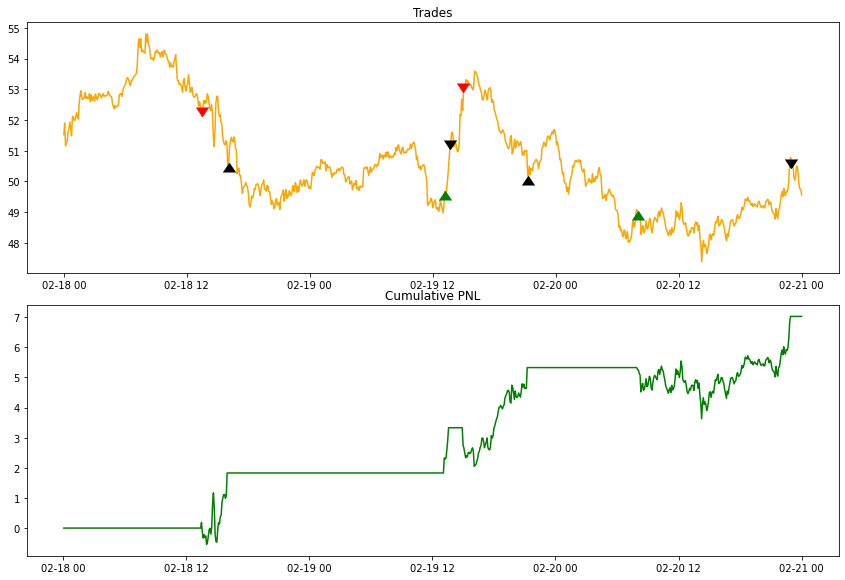

In [4]:
trades_pnl = trading_portfolio.diff() * positions
cumulative_pnl = trades_pnl.cumsum()

fig, axes = plt.subplots(2,1, figsize=(12,8))
fig.tight_layout()
axes[0].plot(trading_portfolio, color='orange')
axes[0].title.set_text("Trades")
axes[0].plot(longs_open_markers, linestyle='None', marker=6, color='g', markersize=12)
axes[0].plot(longs_close_markers, linestyle='None', marker=7, color='black', markersize=12)
axes[0].plot(shorts_open_markers, linestyle='None', marker=7, color='r', markersize=12)
axes[0].plot(shorts_close_markers, linestyle='None', marker=6, color='black', markersize=12)

axes[1].plot(cumulative_pnl, color='g' if cumulative_pnl.iloc[-1] > 0 else 'r')
axes[1].title.set_text("Cumulative PNL")



In [5]:
trades

,position,open_date,open_spread,close_date,close_spread,pnl,duration,weights
0,short,2022-02-18 13:30:00+00:00,52.122871,2022-02-18 16:05:00+00:00,50.586208,1.535587,0 days 02:35:00,"[0.6203178873342555, -0.11171170233416057]"
1,long,2022-02-19 13:10:00+00:00,49.679036,2022-02-19 13:40:00+00:00,51.056968,1.376968,0 days 00:30:00,"[0.6203178873342555, -0.11171170233416057]"
2,short,2022-02-19 15:00:00+00:00,52.900339,2022-02-19 21:20:00+00:00,50.162612,2.735811,0 days 06:20:00,"[0.6203178873342555, -0.11171170233416057]"
3,long,2022-02-20 08:00:00+00:00,49.023007,2022-02-20 23:00:00+00:00,50.454216,1.430207,0 days 15:00:00,"[0.6203178873342555, -0.11171170233416057]"


#### Trades Statistics

In [6]:
print('Trades Statistics')

avg_win = trades[trades['pnl'] > 0]['pnl'].mean()
avg_loss = trades[trades['pnl'] < 0]['pnl'].mean()
avg_trade_pnl = trades['pnl'].mean()
avg_win_duration = trades[trades['pnl'] > 0]['duration'].mean()
avg_loss_duration = trades[trades['pnl'] < 0]['duration'].mean()
avg_duration = trades['duration'].mean()

print('Average: win pnl = {:.2f}, loss pnl = {:.2f}, trade pnl = {:.2f}, win duration = {}, loss duration = {}, trade duration = {}'.format(avg_win, avg_loss, avg_trade_pnl, avg_win_duration, avg_loss_duration, avg_duration))

median_win = trades[trades['pnl'] > 0]['pnl'].median()
median_loss = trades[trades['pnl'] < 0]['pnl'].median()
median_trade_pnl = trades['pnl'].median()
median_win_duration = trades[trades['pnl'] > 0]['duration'].median()
median_loss_duration = trades[trades['pnl'] < 0]['duration'].median()
median_duration = trades['duration'].median()

print('Median: win pnl = {:.2f}, loss pnl = {:.2f}, trade pnl = {:.2f}, win duration = {}, loss duration = {}, trade duration = {}'.format(median_win, median_loss, median_trade_pnl, median_win_duration, median_loss_duration, median_duration))

Trades Statistics
Average: win pnl = 1.77, loss pnl = nan, trade pnl = 1.77, win duration = 0 days 06:06:15, loss duration = NaT, trade duration = 0 days 06:06:15
Median: win pnl = 1.48, loss pnl = nan, trade pnl = 1.48, win duration = 0 days 04:27:30, loss duration = NaT, trade duration = 0 days 04:27:30


#### Mean Reversion (Rolling)

##### Trading signals

In [85]:
taker_fee = 0.0007
formation_window_hours = 3*24
trading_window_hours = 12
formation_start_time = datetime.fromisoformat('2022-01-01 00:00:00+00:00')
backtest_end_time = datetime.fromisoformat('2022-03-01 00:00:00+00:00')
formation_end_time = formation_start_time + timedelta(hours=formation_window_hours)

trades = []
all_formation_prices = []
all_trading_prices = []
while formation_end_time < backtest_end_time:
    
    # Make mean reverting portfolio
    formation_prices = prices[formation_start_time:formation_end_time]
    jres = coint_johansen(formation_prices, 0, 1)
    cointegrated = jres.max_eig_stat[0] > jres.max_eig_stat_crit_vals[0][1]
    evec = jres.evec[0]
    formation_portfolio = (evec * formation_prices).sum(axis=1)
    formation_mean = formation_portfolio.mean()
    formation_std = formation_portfolio.std()

    trading_start_time = formation_end_time
    trading_end_time = formation_end_time + timedelta(hours=trading_window_hours)
    trading_prices = prices[trading_start_time:trading_end_time]
    trading_portfolio = (evec * trading_prices).sum(axis=1)


    # Trading positions
    positions = [0, 0]
    std_multiple = 1
    long_signal = formation_mean - formation_std * std_multiple
    short_signal = formation_mean + formation_std * std_multiple
    exit_signal = formation_mean
    long_stop_signal = formation_mean - formation_std * std_multiple * 2
    short_stop_signal = formation_mean + formation_std * std_multiple * 2
    for i in range(2, len(trading_portfolio.index)):
        if trading_portfolio.iloc[i-2] < long_signal and trading_portfolio.iloc[i-1] > long_signal:
            # open long
            positions.append(1)
        elif trading_portfolio.iloc[i-2] > short_signal and trading_portfolio.iloc[i-1] < short_signal:
            # open short
            positions.append(-1)
        elif positions[i-2] == 1 and trading_portfolio.iloc[i-1] > exit_signal:
            # close long
            positions.append(0)
        elif positions[i-1] == -1 and trading_portfolio.iloc[i-1] < exit_signal:
            # close short
            positions.append(0)
        elif positions[i-1] == 1 and trading_portfolio.iloc[i-1] < long_stop_signal:
            # Take loss
            positions.append(0)
        elif positions[i-1] == -1 and trading_portfolio.iloc[i-1] > short_stop_signal:
            # Take loss
            positions.append(0)
        else:
            positions.append(positions[i-1])


    #trades = []
    for i in range(1, len(positions)):
        # Position opened
        if positions[i-1] == 0 and positions[i] != 0:
            open_spread = trading_portfolio.iloc[i]
            open_trade_index = i

        # Position closed (force close if at last trading bar)
        if positions[i-1] != 0 and (positions[i] == 0 or i == len(positions) - 1):
            open_spread = trading_portfolio.iloc[open_trade_index]
            close_spread = trading_portfolio.iloc[i]
            pnl = ((close_spread - close_spread * taker_fee) - (open_spread - open_spread * taker_fee)) * positions[i-1]

            trades.append({
                'position': 'long' if positions[i-1] > 0 else 'short',
                'open_date': trading_portfolio.index[open_trade_index],
                'open_spread': open_spread,
                'close_date': trading_portfolio.index[i],
                'close_spread': close_spread,
                'pnl': pnl,
                'duration': trading_portfolio.index[i] - trading_portfolio.index[open_trade_index],
                'weights': evec
            })

            open_trade_index = None
    
    # Next period
    formation_start_time = formation_start_time + timedelta(hours=trading_window_hours)
    formation_end_time = formation_end_time + timedelta(hours=trading_window_hours)
    all_formation_prices.append(formation_prices*evec)
    all_trading_prices.append(trading_prices*evec)


trades = pd.DataFrame(trades)



Trade Statistics
winrate = 57.95%
Average: win pnl = 1.22, loss pnl = -1.21, trade pnl = 0.20, win duration = 0 days 04:49:24.705882352, loss duration = 0 days 04:47:25.945945945, trade duration = 0 days 04:48:34.772727272
Median: win pnl = 0.89, loss pnl = -1.22, trade pnl = 0.34, win duration = 0 days 03:50:00, loss duration = 0 days 03:35:00, trade duration = 0 days 03:42:30


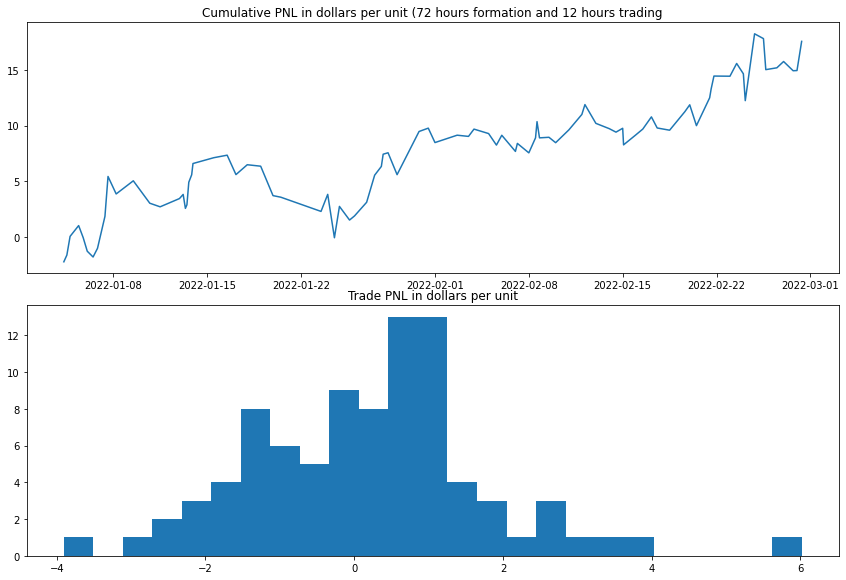

In [104]:
# Visualize
fig, axs = plt.subplots(2,1, figsize=(12,8))
fig.tight_layout()
axs[0].plot(trades['close_date'], trades['pnl'].cumsum())
axs[0].title.set_text('Cumulative PNL in dollars per unit ({} hours formation and {} hours trading)'.format(formation_window_hours, trading_window_hours))
axs[1].hist(trades['pnl'], bins=25)
axs[1].title.set_text('Trade PNL in dollars per unit')

print('Trade Statistics')
winrate = len(trades[trades['pnl'] > 0]) / len(trades)
print('winrate = {:.2f}%'.format(winrate*100))

avg_win = trades[trades['pnl'] > 0]['pnl'].mean()
avg_loss = trades[trades['pnl'] < 0]['pnl'].mean()
avg_trade_pnl = trades['pnl'].mean()
avg_win_duration = trades[trades['pnl'] > 0]['duration'].mean()
avg_loss_duration = trades[trades['pnl'] < 0]['duration'].mean()
avg_duration = trades['duration'].mean()

print('Average: win pnl = {:.2f}, loss pnl = {:.2f}, trade pnl = {:.2f}, win duration = {}, loss duration = {}, trade duration = {}'.format(avg_win, avg_loss, avg_trade_pnl, avg_win_duration, avg_loss_duration, avg_duration))

median_win = trades[trades['pnl'] > 0]['pnl'].median()
median_loss = trades[trades['pnl'] < 0]['pnl'].median()
median_trade_pnl = trades['pnl'].median()
median_win_duration = trades[trades['pnl'] > 0]['duration'].median()
median_loss_duration = trades[trades['pnl'] < 0]['duration'].median()
median_duration = trades['duration'].median()

print('Median: win pnl = {:.2f}, loss pnl = {:.2f}, trade pnl = {:.2f}, win duration = {}, loss duration = {}, trade duration = {}'.format(median_win, median_loss, median_trade_pnl, median_win_duration, median_loss_duration, median_duration))
